Emotive for LSL realtime

https://www.emotiv.com/blogs/tutorials/emotiv-lab-streaming-layer-lsl

FFT

https://github.com/KrishnaVeer7712/DIGITS-CLASSIFICATIONS-USING-ELECTROENCEPHALOGRAPHY-SIGNALS/blob/master/Brain_123%20(1).ipynb

https://github.com/ayushayt/ImaginedSpeechRecognition

In [105]:
import pandas as pd
import numpy as np


data_path = "data/emotiv/EP1.01.txt"

df_emotiv = pd.read_csv(data_path, sep='\t', header=None)



In [106]:
df_emotiv.columns = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
df_emotiv['data'] = df_emotiv['data'].apply(lambda x: list(map(float, x.split(','))))
df_emotiv.head()

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.384615, 4382.564102, 4377.435897, 4387.1..."
1,67636,67635,EP,F7,6,260,"[4489.230769, 4475.384615, 4474.358974, 4486.6..."
2,67637,67635,EP,F3,6,260,"[4538.461538, 4528.717948, 4524.615384, 4526.1..."
3,67638,67635,EP,FC5,6,260,"[4207.692307, 4205.641025, 4200.51282, 4194.35..."
4,67639,67635,EP,T7,6,260,"[4497.948717, 4498.461538, 4494.871794, 4497.9..."


In [107]:
df_emotiv["code"].value_counts()

code
 3    92652
 5    91994
 9    91882
 8    91728
 6    91322
 0    91224
 2    90930
 1    88914
 4    88886
 7    88718
-1     2226
Name: count, dtype: int64

In [108]:
df_emotiv["code"].unique()

array([ 6,  7,  9,  0,  8,  5,  3,  4,  2,  1, -1])

In [109]:
df_emotiv[df_emotiv["code"] == -1].shape[0]

2226

In [110]:
from scipy.signal import resample

def resample_signal(signal, original_rate, target_rate=128):
    num_samples = int(len(signal) * target_rate / original_rate)
    return resample(signal, num_samples)

# Sampling rates of each device
sampling_rates = {
    'MW': 512,  # MindWave
    'EP': 128,  # Emotiv Epoc
    'MU': 220,  # Interaxon Muse / Muse 2
    'IN': 128   # Emotiv Insight
}

# Resample the 'data' column for each device
def resample_device_data(df, device):
    original_rate = sampling_rates[device]
    df["data"] = df["data"].apply(lambda x: resample_signal(x, original_rate))
    return df

df_emotiv = resample_device_data(df_emotiv, 'EP')

In [111]:
df_emotiv_copy = pd.concat([df_emotiv.drop(['data'], axis=1), df_emotiv['data'].apply(pd.Series)], axis=1)

In [112]:
df_emotiv_copy.head()

,id,event,device,channel,code,size,0,1,2,3,...,310,311,312,313,314,315,316,317,318,319
0,67635,67635,EP,AF3,6,260,4395.384615,4382.564102,4377.435897,4387.179487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67636,67635,EP,F7,6,260,4489.230769,4475.384615,4474.358974,4486.666666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67637,67635,EP,F3,6,260,4538.461538,4528.717948,4524.615384,4526.153846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67638,67635,EP,FC5,6,260,4207.692307,4205.641025,4200.512820,4194.358974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67639,67635,EP,T7,6,260,4497.948717,4498.461538,4494.871794,4497.948717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# "data" column is an array of floats get the max length of the array
max_len = df_emotiv["data"].apply(len).max()
print(max_len)

# check the max number in the copied dataframe
print(df_emotiv_copy.columns[-1])
assert max_len == df_emotiv_copy.columns[-1] + 1

320
319


In [114]:
df_emotiv_copy["channel"].unique()

array(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8',
       'FC6', 'F4', 'F8', 'AF4'], dtype=object)

In [115]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Initialize MinMaxScaler for each EEG channel
scalers = {
    "AF3": MinMaxScaler(),
    "F7": MinMaxScaler(),
    "F3": MinMaxScaler(),
    "FC5": MinMaxScaler(),
    "T7": MinMaxScaler(),
    "P7": MinMaxScaler(),
    "O1": MinMaxScaler(),
    "O2": MinMaxScaler(),
    "P8": MinMaxScaler(),
    "T8": MinMaxScaler(),
    "FC6": MinMaxScaler(),
    "F4": MinMaxScaler(),
    "F8": MinMaxScaler(),
    "AF4": MinMaxScaler()
}

# get columns that are not string
crucial_columns = ['id', 'event', 'device', 'channel', 'code', 'size', 'is_num']

# get non crucial columns
non_crucial_columns = [col for col in df_emotiv_copy.columns if col not in crucial_columns]

# Create a new DataFrame with the scaled and filtered data
df_emotiv_scaled = df_emotiv_copy.copy()

# for channel in scalers.keys():
#     print(df_emotiv_scaled.loc[df_emotiv_scaled["channel"] == channel, non_crucial_columns].shape)
#     # change the shape to (n_samples, 1)
#     data = df_emotiv_scaled.loc[df_emotiv_scaled["channel"] == channel, non_crucial_columns].values.reshape(-1, 1)
#     sclaed_data = scalers[channel].fit_transform(data)
#     df_emotiv_scaled.loc[df_emotiv_scaled["channel"] == channel, non_crucial_columns] = sclaed_data

# Save all scalers in one .pkl file
joblib.dump(scalers, "all_muse_channel_scalers.pkl")


['all_muse_channel_scalers.pkl']

In [116]:
df_emotiv_scaled.head()

,id,event,device,channel,code,size,0,1,2,3,...,310,311,312,313,314,315,316,317,318,319
0,67635,67635,EP,AF3,6,260,4395.384615,4382.564102,4377.435897,4387.179487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67636,67635,EP,F7,6,260,4489.230769,4475.384615,4474.358974,4486.666666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67637,67635,EP,F3,6,260,4538.461538,4528.717948,4524.615384,4526.153846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67638,67635,EP,FC5,6,260,4207.692307,4205.641025,4200.512820,4194.358974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67639,67635,EP,T7,6,260,4497.948717,4498.461538,4494.871794,4497.948717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The most commonly studied waveforms include delta (0.5 to 4Hz); theta (4 to 7Hz); alpha (8 to 12Hz); sigma (12 to 16Hz) and beta (13 to 30Hz)

In [117]:
delta_min = 0.5
delta_max = 4
theta_min = 4
theta_max = 7
alpha_min = 8
alpha_max = 12
sigma_min = 12
sigma_max = 16
beta_min = 13
beta_max = 30
gamma_min = 30
gamma_max = 64

In [118]:
df_emotiv_scaled[non_crucial_columns].max()

0      6147.483647
1      6147.483647
2      6147.483647
3      6147.483647
4      6147.483647
          ...     
315    4651.282051
316    4652.307692
317    4651.794871
318    4645.641025
319    4637.948717
Length: 320, dtype: float64

In [119]:
df_emotiv_scaled.isnull().sum().sum()

np.int64(55072962)

In [120]:
# this gives the null values of each column
l=df_emotiv_scaled.isnull().sum()
c=0
col_idx = 0
for i in l:
  c=c+1
  if(i!=0):
    print(c, i)
    print(df_emotiv_scaled[column].isnull().sum())
    break
  column = df_emotiv_scaled.columns[c-1]
  col_idx = c-1
print(column)

if col_idx != 0:
  cols_to_remove = range(col_idx, len(df_emotiv_scaled.columns))

  df_emotiv_scaled.drop(df_emotiv_scaled.columns[cols_to_remove], axis=1, inplace=True)

  df_emotiv_scaled.head()


143 14
0
135


In [121]:
df_emotiv_scaled.isnull().sum().sum()

np.int64(0)

In [122]:
print(df_emotiv_scaled["channel"].unique())

['AF3' 'F7' 'F3' 'FC5' 'T7' 'P7' 'O1' 'O2' 'P8' 'T8' 'FC6' 'F4' 'F8' 'AF4']


In [124]:
print(df_emotiv_scaled.head())

      id  event device channel  code  size            0            1  \
0  67635  67635     EP     AF3     6   260  4395.384615  4382.564102   
1  67636  67635     EP      F7     6   260  4489.230769  4475.384615   
2  67637  67635     EP      F3     6   260  4538.461538  4528.717948   
3  67638  67635     EP     FC5     6   260  4207.692307  4205.641025   
4  67639  67635     EP      T7     6   260  4497.948717  4498.461538   

             2            3  ...          125          126          127  \
0  4377.435897  4387.179487  ...  4378.974358  4373.333333  4370.769230   
1  4474.358974  4486.666666  ...  4500.512820  4489.743589  4487.179487   
2  4524.615384  4526.153846  ...  4517.435897  4511.794871  4516.923076   
3  4200.512820  4194.358974  ...  4213.846153  4210.256410  4207.179487   
4  4494.871794  4497.948717  ...  4513.846153  4507.179487  4508.205128   

           128          129          130          131          132  \
0  4376.923076  4382.564102  4384.615384  4386

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
(65034, 135)


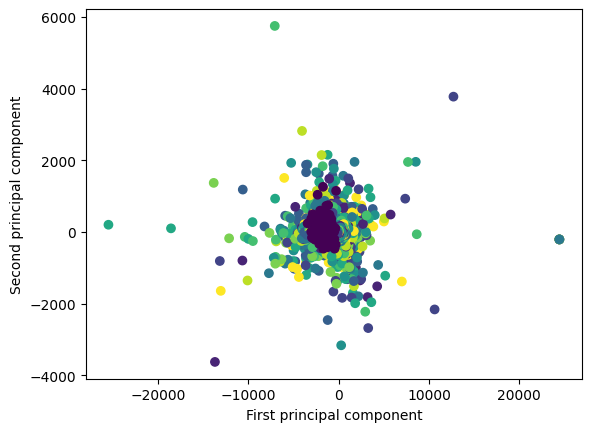

In [125]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# get the data between -1 and non -1 values
# Filter with .copy() to avoid SettingWithCopyWarning
non_minus_1 = df_emotiv_scaled[df_emotiv_scaled["code"] != -1].copy()
minus_1 = df_emotiv_scaled[df_emotiv_scaled["code"] == -1].copy()

channel = "AF4"
# Get tp9 data and create copies
non_minus_1_tp9 = non_minus_1[non_minus_1["channel"] == channel].copy()
minus_1_tp9 = minus_1[minus_1["channel"] == channel].copy()

# Set values
non_minus_1_tp9["is_num"] = 1
minus_1_tp9["is_num"] = 0

all_tp9 = pd.concat([non_minus_1_tp9, minus_1_tp9])

predictor_columns = [col for col in all_tp9.columns if col not in crucial_columns]

print(predictor_columns)
# now we will plot the pca of the data by 0 and 1
pca = PCA(n_components=2)

X = all_tp9[predictor_columns].values
y_binary = all_tp9["is_num"].values
y_code = all_tp9["code"].values


X_pca = pca.fit_transform(X)
print(X.shape)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_code, cmap='viridis')
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_code, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()


In [246]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, lfilter

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    # y = filtfilt(b, a, data)
    return y

filtered_df = pd.DataFrame()

channel_columns = df_emotiv_scaled["channel"].unique()

predictor_columns = [col for col in all_tp9.columns if col not in crucial_columns]
lowcut = delta_min  
highcut = delta_max
fs = 128
order = 4

df = df_emotiv_scaled.copy()

signal_columns = predictor_columns
# Loop through each channel
signal_data = df[signal_columns].astype(float)

In [247]:
signal_data.transpose().shape

(135, 910476)

In [248]:
signal_data.transpose().head(1)

,0,1,2,3,4,5,6,7,8,9,...,910466,910467,910468,910469,910470,910471,910472,910473,910474,910475
0,4395.384615,4489.230769,4538.461538,4207.692307,4497.948717,4203.076923,4203.076923,4229.743589,4245.641025,4506.666666,...,4492.307692,4214.871794,4457.948717,4202.051282,4255.897435,4528.205128,4230.76923,4576.410256,3949.23077,3925.128206


In [249]:
signal_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,...,4378.974358,4373.333333,4370.76923,4376.923076,4382.564102,4384.615384,4386.666666,4384.102564,4380.51282,4375.897435


In [250]:
signal_data.iloc[0].values

array([4395.384615, 4382.564102, 4377.435897, 4387.179487, 4395.897435,
       4398.461538, 4396.923076, 4391.794871, 4391.282051, 4395.897435,
       4398.974358, 4396.410256, 4392.820512, 4392.820512, 4395.384615,
       4398.974358, 4394.358974, 4381.538461, 4376.410256, 4383.589743,
       4387.179487, 4388.717948, 4397.948717, 4401.538461, 4397.948717,
       4398.974358, 4398.974358, 4395.897435, 4396.923076, 4398.461538,
       4397.948717, 4396.410256, 4391.794871, 4389.743589, 4389.743589,
       4385.641025, 4387.692307, 4393.846153, 4389.743589, 4381.025641,
       4377.948717, 4378.461538, 4377.435897, 4385.128205, 4393.333333,
       4389.230769, 4382.564102, 4378.974358, 4375.384615, 4378.461538,
       4386.153846, 4389.230769, 4393.846153, 4390.25641 , 4374.871794,
       4367.692307, 4374.871794, 4384.615384, 4390.76923 , 4394.358974,
       4390.76923 , 4382.051282, 4381.025641, 4385.641025, 4376.923076,
       4365.641025, 4373.333333, 4377.948717, 4365.128205, 4363.

In [251]:
signal_array = signal_data.values
print(signal_array.shape)
filtered_signal = bandpass_filter(signal_array, lowcut, highcut, fs, order)

(910476, 135)


In [252]:
filtered_signal.shape

(910476, 135)

In [253]:
signal_data

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,...,4378.974358,4373.333333,4370.769230,4376.923076,4382.564102,4384.615384,4386.666666,4384.102564,4380.512820,4375.897435
1,4489.230769,4475.384615,4474.358974,4486.666666,4498.974358,4496.410256,4486.666666,4489.743589,4498.461538,4500.000000,...,4500.512820,4489.743589,4487.179487,4494.871794,4502.564102,4511.282051,4514.871794,4505.641025,4499.487179,4504.102564
2,4538.461538,4528.717948,4524.615384,4526.153846,4532.307692,4538.461538,4535.384615,4528.205128,4528.717948,4531.794871,...,4517.435897,4511.794871,4516.923076,4524.102564,4528.717948,4530.769230,4526.153846,4520.000000,4518.974358,4516.410256
3,4207.692307,4205.641025,4200.512820,4194.358974,4198.461538,4213.846153,4219.487179,4210.769230,4202.564102,4198.974358,...,4213.846153,4210.256410,4207.179487,4210.769230,4214.358974,4215.384615,4216.923076,4216.923076,4213.333333,4204.102564
4,4497.948717,4498.461538,4494.871794,4497.948717,4506.153846,4508.205128,4501.538461,4497.435897,4498.461538,4502.051282,...,4513.846153,4507.179487,4508.205128,4507.692307,4506.666666,4511.794871,4514.871794,4512.307692,4509.230769,4503.589743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910471,4528.205128,4526.153846,4525.128205,4516.410256,4518.974358,4538.461538,4535.897435,4514.358974,4507.692307,4511.794871,...,4569.230769,4564.615384,4572.307692,4568.205128,4550.256410,4557.948717,4570.256410,4562.564102,4556.410256,4557.948717
910472,4230.769230,4228.205128,4237.435897,4234.871794,4220.000000,4218.461538,4231.794871,4245.128205,4241.025641,4222.564102,...,4315.384615,4313.333333,4328.205128,4329.230769,4321.025641,4320.512820,4308.717948,4303.076923,4320.000000,4315.384615
910473,4576.410256,4576.410256,4581.538461,4580.000000,4578.461538,4579.487179,4578.974358,4583.076923,4583.589743,4570.769230,...,4625.128205,4627.692307,4636.923076,4630.256410,4621.025641,4626.153846,4622.051282,4616.410256,4625.641025,4624.615384
910474,3949.230770,3947.179488,3946.666667,3944.102565,3946.153847,3950.769231,3949.743590,3951.794872,3955.897436,3946.153847,...,4063.076923,4065.641025,4074.358974,4073.846153,4063.589743,4058.461538,4051.282051,4053.846153,4062.564102,4041.025641


In [254]:
signal_data[0]

0         4395.384615
1         4489.230769
2         4538.461538
3         4207.692307
4         4497.948717
             ...     
910471    4528.205128
910472    4230.769230
910473    4576.410256
910474    3949.230770
910475    3925.128206
Name: 0, Length: 910476, dtype: float64

In [255]:
filtered_signal.max()

np.float64(3264.7674039078843)

In [256]:
signal_array.shape

(910476, 135)

In [262]:
alpha_signal = bandpass_filter(signal_array, alpha_min, alpha_max, fs, order)
delta_signal = bandpass_filter(signal_array, delta_min, delta_max, fs, order)
theta_signal = bandpass_filter(signal_array, theta_min, theta_max, fs, order)
beta_signal = bandpass_filter(signal_array, beta_min, beta_max, fs, order)
# max_threshold = 45
# gamma_signal = bandpass_filter(signal_array, max_threshold, gamma_max, fs, order)
print(alpha_signal.shape)
filtered_alpha = pd.DataFrame(alpha_signal, columns=signal_columns)
filtered_delta = pd.DataFrame(delta_signal, columns=signal_columns)
filtered_theta = pd.DataFrame(theta_signal, columns=signal_columns)
filtered_beta = pd.DataFrame(beta_signal, columns=signal_columns)
print(filtered_alpha.shape)

metadata_columns = [col for col in df.columns if col not in signal_columns]

filtered_alpha_df = pd.concat([df[metadata_columns].reset_index(drop=True), filtered_alpha], axis=1)
filtered_delta_df = pd.concat([df[metadata_columns].reset_index(drop=True), filtered_delta], axis=1)
filtered_theta_df = pd.concat([df[metadata_columns].reset_index(drop=True), filtered_theta], axis=1)
filtered_beta_df = pd.concat([df[metadata_columns].reset_index(drop=True), filtered_beta], axis=1)




(910476, 135)
(910476, 135)


In [263]:
filtered_alpha_df.isnull().sum().sum()

np.int64(0)

In [264]:
filtered_alpha_df.head()

,id,event,device,channel,code,size,0,1,2,3,...,125,126,127,128,129,130,131,132,133,134
0,67635,67635,EP,AF3,6,260,0.319863,2.441277,8.833889,20.215495,...,0.653506,-6.551023,-12.596605,-16.544192,-17.764202,-16.056485,-11.710790,-5.487061,1.497060,7.964270
1,67636,67635,EP,F7,6,260,0.326693,2.493346,9.022391,20.648117,...,2.097140,-4.861471,-11.140305,-15.733453,-17.813299,-16.912950,-13.071749,-6.898021,0.488931,7.653429
2,67637,67635,EP,F3,6,260,0.330275,2.520999,9.123475,20.880613,...,-0.531233,-7.246105,-12.804838,-16.373943,-17.354362,-15.517537,-11.105441,-4.850519,2.118148,8.485211
3,67638,67635,EP,FC5,6,260,0.306204,2.337773,8.462327,19.371563,...,0.121407,-6.178547,-11.398471,-14.814767,-15.923145,-14.531625,-10.828014,-5.394832,0.852282,6.808419
4,67639,67635,EP,T7,6,260,0.327327,2.499235,9.047719,20.715055,...,-2.983416,-8.855454,-13.008681,-15.015856,-14.759523,-12.420512,-8.437912,-3.446137,1.804376,6.539065


Text(0.5, 1.0, 'Delta Band')

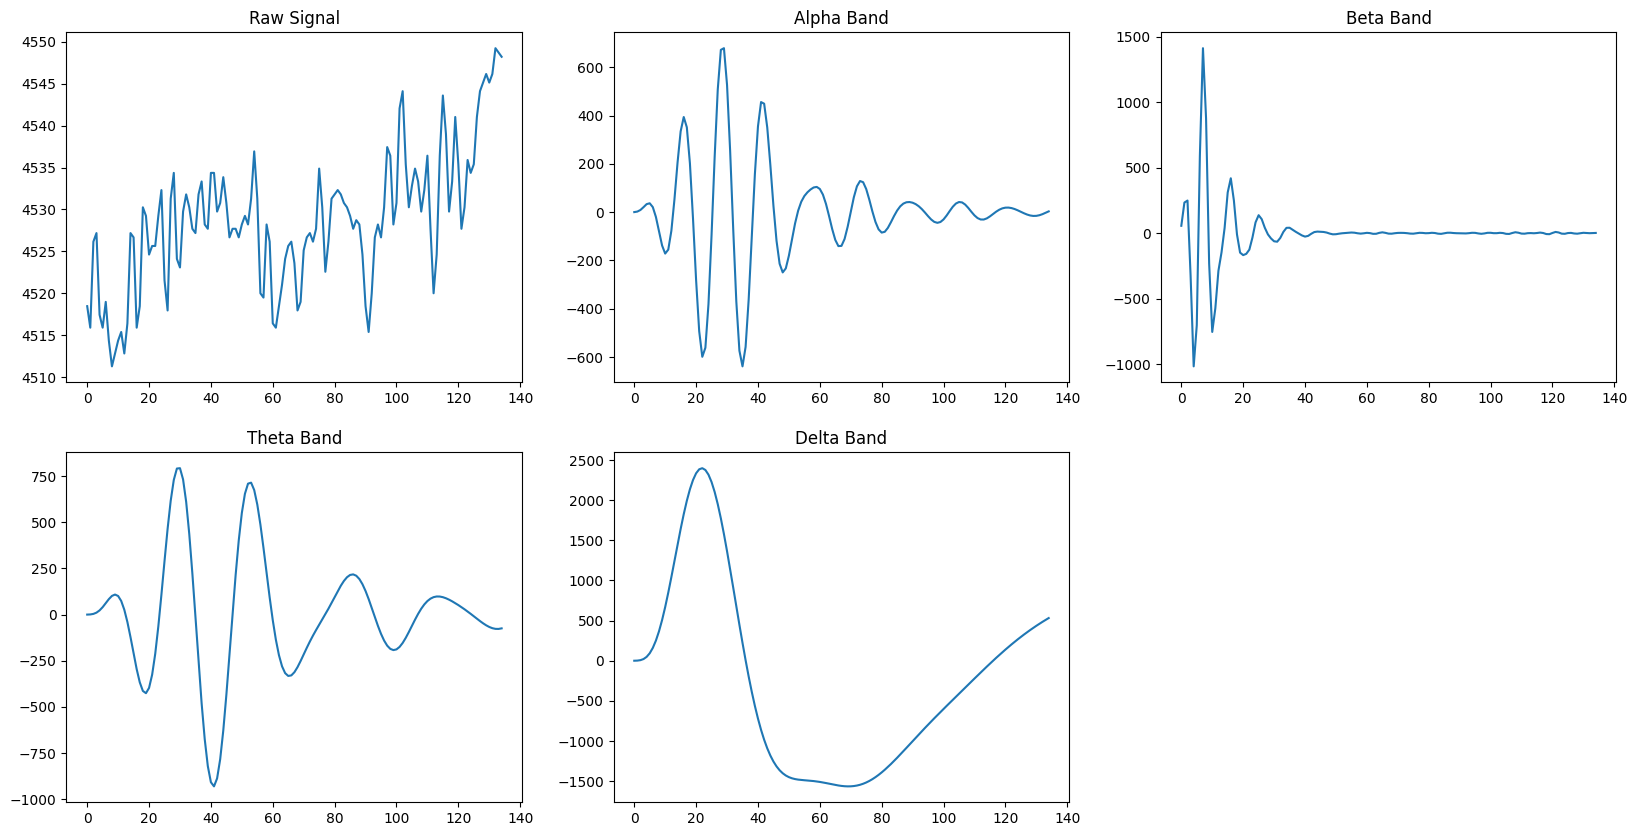

In [265]:
# plot df_emotiv_scaled by predictor column
index = 100
single_row_raw = df_emotiv_copy.iloc[index][predictor_columns]
alpha_row = filtered_alpha_df.iloc[index][predictor_columns]
beta_row = filtered_beta_df.iloc[index][predictor_columns]
theta_row = filtered_theta_df.iloc[index][predictor_columns]
delta_row = filtered_delta_df.iloc[index][predictor_columns]


# plot raw and the 4 filtere signals side by side
plt.figure(figsize=(20, 10))
# left
plt.subplot(2, 3, 1)
plt.plot(single_row_raw)
plt.title("Raw Signal")
# middle
plt.subplot(2, 3, 2)
plt.plot(alpha_row)
plt.title("Alpha Band")
# middle
plt.subplot(2, 3, 3)
plt.plot(beta_row)
plt.title("Beta Band")
# right
plt.subplot(2, 3, 4)
plt.plot(theta_row)
plt.title("Theta Band")
# right
plt.subplot(2, 3, 5)
plt.plot(delta_row)
plt.title("Delta Band")


In [266]:
filtered_alpha_df.tail()

,id,event,device,channel,code,size,0,1,2,3,...,125,126,127,128,129,130,131,132,133,134
910471,978106,132668,EP,T8,-1,256,0.329529,2.515860,9.107342,20.849813,...,-3.118329,-6.837774,-9.477397,-11.058608,-11.545053,-10.820289,-8.766760,-5.395190,-0.968270,3.936948
910472,978107,132668,EP,FC6,-1,256,0.307884,2.350558,8.509507,19.485054,...,-1.916882,-7.905085,-12.265922,-14.610541,-14.787188,-12.861766,-9.128746,-4.123514,1.403361,6.576886
910473,978108,132668,EP,F4,-1,256,0.333037,2.542793,9.205895,21.079895,...,-1.969492,-7.236780,-11.196995,-13.630849,-14.394658,-13.401245,-10.668801,-6.402911,-1.065072,4.620485
910474,978109,132668,EP,F8,-1,256,0.287396,2.194164,7.942763,18.184016,...,-1.532056,-6.998350,-10.853821,-12.832067,-12.913869,-11.263605,-8.194834,-4.152612,0.310998,4.582659
910475,978110,132668,EP,AF4,-1,256,0.285642,2.180734,7.894742,18.077751,...,-1.347145,-6.881507,-10.815366,-12.862166,-13.007196,-11.430252,-8.450813,-4.495701,-0.075980,4.243725


In [267]:
filtered_alpha_df.head()

,id,event,device,channel,code,size,0,1,2,3,...,125,126,127,128,129,130,131,132,133,134
0,67635,67635,EP,AF3,6,260,0.319863,2.441277,8.833889,20.215495,...,0.653506,-6.551023,-12.596605,-16.544192,-17.764202,-16.056485,-11.710790,-5.487061,1.497060,7.964270
1,67636,67635,EP,F7,6,260,0.326693,2.493346,9.022391,20.648117,...,2.097140,-4.861471,-11.140305,-15.733453,-17.813299,-16.912950,-13.071749,-6.898021,0.488931,7.653429
2,67637,67635,EP,F3,6,260,0.330275,2.520999,9.123475,20.880613,...,-0.531233,-7.246105,-12.804838,-16.373943,-17.354362,-15.517537,-11.105441,-4.850519,2.118148,8.485211
3,67638,67635,EP,FC5,6,260,0.306204,2.337773,8.462327,19.371563,...,0.121407,-6.178547,-11.398471,-14.814767,-15.923145,-14.531625,-10.828014,-5.394832,0.852282,6.808419
4,67639,67635,EP,T7,6,260,0.327327,2.499235,9.047719,20.715055,...,-2.983416,-8.855454,-13.008681,-15.015856,-14.759523,-12.420512,-8.437912,-3.446137,1.804376,6.539065


In [268]:
print(filtered_alpha_df[signal_columns].max().max())
print(filtered_alpha_df[signal_columns].min().min())
print(filtered_beta_df[signal_columns].max().max())
print(filtered_beta_df[signal_columns].min().min())
print(filtered_theta_df[signal_columns].max().max())
print(filtered_theta_df[signal_columns].min().min())
print(filtered_delta_df[signal_columns].max().max())
print(filtered_delta_df[signal_columns].min().min())

1243.5490524929678
-1259.177889612164
2364.038469880754
-1696.2524824988393
1623.335128211173
-1589.7496951768142
3264.7674039078843
-4163.855674432968


In [153]:
final_df.head()

,id,event,device,channel,code,size,0,1,2,3,...,125,126,127,128,129,130,131,132,133,134
0,67635,67635,EP,AF3,6,260,4.340086,4.020391,3.718880,3.442220,...,4.843144,4.680518,4.478199,4.240256,3.971681,3.678210,3.366128,3.042065,2.712768,2.384874
1,67636,67635,EP,F7,6,260,3.426560,4.080721,4.733261,5.379216,...,2.165101,2.102054,2.031408,1.952944,1.866806,1.773434,1.673520,1.567963,1.457832,1.344322
2,67637,67635,EP,F3,6,260,2.723328,2.062206,1.419215,0.806953,...,3.850529,3.657517,3.439160,3.197713,2.936444,2.659521,2.371865,2.078949,1.786567,1.500573
3,67638,67635,EP,FC5,6,260,3.176555,2.964508,2.766792,2.588617,...,6.109114,5.986575,5.792969,5.532323,5.210869,4.836825,4.420088,3.971841,3.504099,3.029207
4,67639,67635,EP,T7,6,260,2.898900,3.160995,3.436895,3.728457,...,3.710378,3.737541,3.706335,3.617097,3.472427,3.277050,3.037586,2.762221,2.460313,2.141931


In [154]:
predictor_columns

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134]

In [155]:
channel_order = df_emotiv_scaled["channel"].unique()
channel_order

array(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8',
       'FC6', 'F4', 'F8', 'AF4'], dtype=object)

In [156]:
# all_tp9
# get value count of code frequencies
all_tp9["code"].value_counts()

code
 3    6618
 5    6571
 9    6563
 8    6552
 6    6523
 0    6516
 2    6495
 1    6351
 4    6349
 7    6337
-1     159
Name: count, dtype: int64

In [157]:
event_unique = all_tp9["event"].unique()
print(len(event_unique))

65034


In [158]:
channel_order

array(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8',
       'FC6', 'F4', 'F8', 'AF4'], dtype=object)

In [159]:
af3 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "AF3"]
f7 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "F7"]
f3 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "F3"]
fc5 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "FC5"]
t7 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "T7"]
p7 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "P7"]
o1 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "O1"]
o2 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "O2"]
p8 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "P8"]
t8 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "T8"]
fc6 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "FC6"]
f4 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "F4"]
f8 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "F8"]
af4 = df_emotiv_scaled[df_emotiv_scaled["channel"] == "AF4"]


print(af3.shape, f7.shape, f3.shape, fc5.shape, t7.shape, p7.shape, o1.shape, o2.shape, p8.shape, t8.shape, fc6.shape, f4.shape, f8.shape, af4.shape)

(65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141) (65034, 141)


In [172]:
# get delta, theta, alpha, beta 
def get_band_signal(df, channel, fs, order):
    print(df.isnull().sum().sum()) 
    df_vals = df[df["channel"] == channel][predictor_columns].values
    alpha_signal = bandpass_filter(df_vals, alpha_min, alpha_max, fs, order)
    delta_signal = bandpass_filter(df_vals, delta_min, delta_max, fs, order)
    theta_signal = bandpass_filter(df_vals, theta_min, theta_max, fs, order)
    beta_signal = bandpass_filter(df_vals, beta_min, beta_max, fs, order)
    
    filtered_alpha = pd.DataFrame(alpha_signal, columns=signal_columns)
    filtered_delta = pd.DataFrame(delta_signal, columns=signal_columns)
    filtered_theta = pd.DataFrame(theta_signal, columns=signal_columns)
    filtered_beta = pd.DataFrame(beta_signal, columns=signal_columns)
    print(filtered_alpha.isnull().sum().sum())

    metadata_columns = [col for col in df.columns if col not in signal_columns]\
    
    # combine metadata with filtered signal data
    filtered_alpha_df = pd.concat([df[df["channel"] == channel][metadata_columns].reset_index(drop=True), filtered_alpha], axis=1)
    filtered_delta_df = pd.concat([df[df["channel"] == channel][metadata_columns].reset_index(drop=True), filtered_delta], axis=1)  
    filtered_theta_df = pd.concat([df[df["channel"] == channel][metadata_columns].reset_index(drop=True), filtered_theta], axis=1)
    filtered_beta_df = pd.concat([df[df["channel"] == channel][metadata_columns].reset_index(drop=True), filtered_beta], axis=1)
    print(filtered_alpha_df.isnull().sum().sum())
    
    return filtered_alpha_df, filtered_delta_df, filtered_theta_df, filtered_beta_df


alpha, delta, theta, beta = get_band_signal(df_emotiv_scaled, "AF3", 128, 4)
print(df_emotiv_scaled.shape)
print(alpha.shape)

0
0
0
(910476, 141)
(65034, 141)


In [161]:
df_emotiv_scaled.isnull().sum()

id         0
event      0
device     0
channel    0
code       0
          ..
130        0
131        0
132        0
133        0
134        0
Length: 141, dtype: int64

In [162]:
alpha.isnull().sum()

id              0
event           0
device          0
channel         0
code            0
            ...  
130        845442
131        845442
132        845442
133        845442
134        845442
Length: 141, dtype: int64

In [140]:
X = []
X_uncat = []
y = []

for i in range(0, len(af3)):
    af3_v = af3.iloc[i][predictor_columns].values
    f7_v = f7.iloc[i][predictor_columns].values
    f3_v = f3.iloc[i][predictor_columns].values
    fc5_v = fc5.iloc[i][predictor_columns].values
    t7_v = t7.iloc[i][predictor_columns].values
    p7_v = p7.iloc[i][predictor_columns].values
    o1_v = o1.iloc[i][predictor_columns].values
    o2_v = o2.iloc[i][predictor_columns].values
    p8_v = p8.iloc[i][predictor_columns].values
    t8_v = t8.iloc[i][predictor_columns].values
    fc6_v = fc6.iloc[i][predictor_columns].values
    f4_v = f4.iloc[i][predictor_columns].values
    f8_v = f8.iloc[i][predictor_columns].values
    af4_v = af4.iloc[i][predictor_columns].values
    print(af3_v.shape, f7_v.shape, f3_v.shape, fc5_v.shape, t7_v.shape, p7_v.shape, o1_v.shape, o2_v.shape, p8_v.shape, t8_v.shape, fc6_v.shape, f4_v.shape, f8_v.shape, af4_v.shape)
    break
    X.append(np.concatenate((af3_v, f7_v, f3_v, fc5_v, t7_v, p7_v, o1_v, o2_v, p8_v, t8_v, fc6_v, f4_v, f8_v, af4_v)))
    X_uncat.append([af3_v, f7_v, f3_v, fc5_v, t7_v, p7_v, o1_v, o2_v, p8_v, t8_v, fc6_v, f4_v, f8_v, af4_v])
    if af3.iloc[i]["code"] == -1:
        y.append(10)
    else:
        y.append(af3.iloc[i]["code"])

(135,) (135,) (135,) (135,) (135,) (135,) (135,) (135,) (135,) (135,) (135,) (135,) (135,) (135,)


In [ ]:
X = []
X_uncat = []
y = []

for i in range(0, len(af3)):
    af3_v = af3.iloc[i][predictor_columns].values
    f7_v = f7.iloc[i][predictor_columns].values
    f3_v = f3.iloc[i][predictor_columns].values
    fc5_v = fc5.iloc[i][predictor_columns].values
    t7_v = t7.iloc[i][predictor_columns].values
    p7_v = p7.iloc[i][predictor_columns].values
    o1_v = o1.iloc[i][predictor_columns].values
    o2_v = o2.iloc[i][predictor_columns].values
    p8_v = p8.iloc[i][predictor_columns].values
    t8_v = t8.iloc[i][predictor_columns].values
    fc6_v = fc6.iloc[i][predictor_columns].values
    f4_v = f4.iloc[i][predictor_columns].values
    f8_v = f8.iloc[i][predictor_columns].values
    af4_v = af4.iloc[i][predictor_columns].values
    print(af3_v.shape, f7_v.shape, f3_v.shape, fc5_v.shape, t7_v.shape, p7_v.shape, o1_v.shape, o2_v.shape, p8_v.shape, t8_v.shape, fc6_v.shape, f4_v.shape, f8_v.shape, af4_v.shape)
    break
    X.append(np.concatenate((af3_v, f7_v, f3_v, fc5_v, t7_v, p7_v, o1_v, o2_v, p8_v, t8_v, fc6_v, f4_v, f8_v, af4_v)))
    X_uncat.append([af3_v, f7_v, f3_v, fc5_v, t7_v, p7_v, o1_v, o2_v, p8_v, t8_v, fc6_v, f4_v, f8_v, af4_v])
    if af3.iloc[i]["code"] == -1:
        y.append(10)
    else:
        y.append(af3.iloc[i]["code"])

In [136]:
X = np.array(X, dtype=np.float32)
X_uncat = np.array(X_uncat, dtype=np.float32)
X_uncat = X_uncat.transpose(0, 2, 1)
y = np.array(y)
print(X.shape, y.shape, X_uncat.shape)

(65034, 1890) (65034,) (65034, 135, 14)


In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Initialize the RandomForest model
rf = RandomForestClassifier(n_estimators=100)

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5)


# X should have all 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

print(predictions)

[5 7 3 ... 5 4 1]


In [138]:
# accuracy
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.11117090797263013


In [139]:
# save rf model
joblib.dump(rf, "rf_model_emotiv_1890.pkl")

['rf_model_emotiv_1890.pkl']

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


X_train, X_test, y_train, y_test = train_test_split(X_uncat, y, test_size=0.2, random_state=42)
# X_train = X_train.transpose(0, 2, 1)
# X_test = X_test.transpose(0, 2, 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Define the PyTorch model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(14)  # Channels should match input shape
        self.conv1 = nn.Conv1d(14, 128, kernel_size=10, stride=1, padding='same')
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(128, 11)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Switch to (batch, channels, sequence)
        x = self.batch_norm1(x)
        x = F.relu(self.conv1(x))
        x = self.batch_norm2(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # Reorder for LSTM (batch, sequence, input_size)
        x, _ = self.lstm(x)
        x = self.batch_norm3(x[:, -1, :])  # Use the last LSTM output
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.output(x)
        return F.log_softmax(x, dim=1)


(52027, 135, 14) (52027,) (13007, 135, 14) (13007,)


In [108]:
# apple gpu 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [110]:
# Instantiate model, define loss and optimizer
model = EEGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Instantiate model, define loss and optimizer
model = EEGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



# Early stopping criteria
best_accuracy = 0
patience = 10
trigger_times = 0


# Training loop
for epoch in range(1):
    model.train()
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_Y.to(device))
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train_tensor)
        val_loss = criterion(val_outputs, y_train_tensor)
        _, val_preds = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_train_tensor.cpu().numpy(), val_preds.cpu().numpy())
        print(f"Epoch {epoch+1}, Validation Accuracy: {val_accuracy}")

        # Early stopping logic
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping")
                break


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the adapted model with Conv1D, LSTM, and Dense layers
# Example LSTM model



class BrainWaveLSTM(nn.Module):
    def __init__(self, input_channels, hidden_size, output_size, num_layers=1):
        super(BrainWaveLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=input_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step's output
        out = self.fc(out[:, -1, :])
        return out



In [71]:
accuracy_score(y_test, predictions)

0.11147843468901361

In [ ]:
# save the model